In [1]:
import os
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.io import read_pkl
from src.default_paths import path_root
from src.mappings import model_names, task_names

In [2]:
PATH_TO_RESULTS = os.path.join(path_root, "data", "evaluate", "adapter_models_few_shots")

In [3]:
def list_dir(path: str):
    """get list of file/directory names excluding nb checkpoints"""
    
    return [
        x for x in os.listdir(path)
        if x != ".ipynb_checkpoints"
    ]

In [4]:
df_results = pd.DataFrame()

models = list_dir(PATH_TO_RESULTS)

for model in models:
    
    tasks = list_dir(os.path.join(PATH_TO_RESULTS, model))
    model_name = '_'.join(model.split('_')[:-2])
    train_n = model.split('_')[-2]
    train_iter = model.split('_')[-1]
    
    for task in tasks:
        try:
            result = read_pkl(os.path.join(PATH_TO_RESULTS, model, task, "results.pkl"))
            row = {
                "Model": [model_name],
                "Task": task,
                "n_shots": train_n,
                "train_iter": train_iter,
                "AUROC": result['auroc'],
                "AUPRC": result['auprc'],
            }
        except:
            row = {
                "Model": [model_name],
                "Task": task,
                "n_shots": train_n,
                "train_iter": train_iter,
                "AUROC": np.nan,
                "AUPRC": np.nan,
            }

        df_results = pd.concat((df_results, pd.DataFrame(row)))

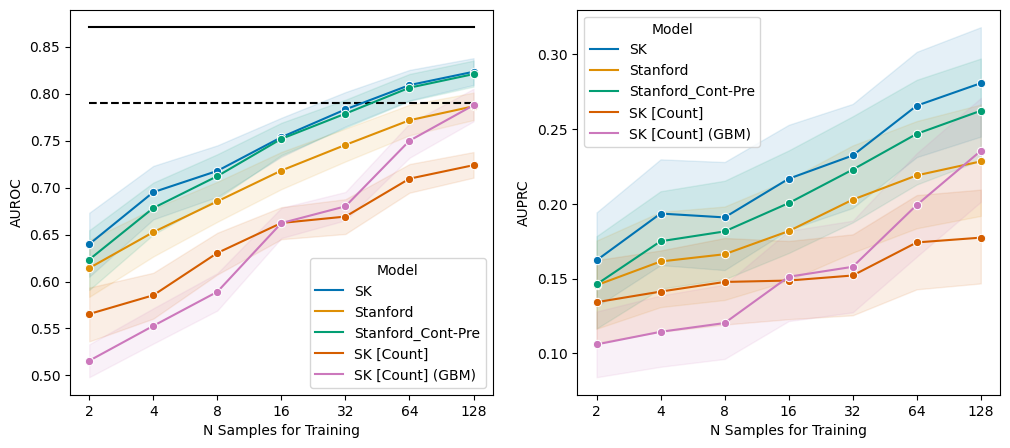

In [6]:
# Average across all
tasks = ['long_los', 'mortality', 'readmission']
tasks_mapped = [task_names[t] for t in tasks]
base_count_auroc = np.mean(pd.read_csv("../results/main_auroc.csv").query("Task==@tasks_mapped")['SK [Count]'])
base_clmbr_auroc = np.mean(pd.read_csv("../results/main_auroc.csv").query("Task==@tasks_mapped")['SK'])
base_count_auprc = np.mean(pd.read_csv("../results/main_auprc.csv").query("Task==@tasks_mapped")['SK [Count]'])
base_clmbr_auprc = np.mean(pd.read_csv("../results/main_auprc.csv").query("Task==@tasks_mapped")['SK'])

models = ['count_sk', 'count_sk_gbm', 'clmbr_sk', 'clmbr_stanford', 'clmbr_stanford_cp']

df_mean = (
    df_results.query("Task==@tasks and Model==@models")
    .groupby(["n_shots", "Model", "Task", "train_iter"])
    [["AUROC", "AUPRC"]]
    .first()
    .reindex(["2", "4", "8", "16", "32", "64", "128"], level=0)
    .reset_index()
    .replace({**model_names})
)

models = df_mean["Model"].unique().tolist()

fig, axes = plt.subplots(1,2,figsize=(12,5))
for c, metric in enumerate(["AUROC", "AUPRC"]):
    
    if metric == "AUROC":
        axes[c].plot(
            df_mean.n_shots.unique(), 
            [base_count_auroc]*len(df_mean.n_shots.unique()),
            'k--'
        )
        
        axes[c].plot(
            df_mean.n_shots.unique(), 
            [base_clmbr_auroc]*len(df_mean.n_shots.unique()),
            'k-'
        )
    
    sns.lineplot(
        data = df_mean,
        x = "n_shots",
        y = metric,
        hue = "Model",
        marker = "o",
        ax = axes[c],
        legend = True,
        palette = "colorblind",
        errorbar = "ci",
        n_boot = 10000,
        err_kws = {"alpha":0.1}
    )

    axes[c].set_xlabel("N Samples for Training")
        
plt.show()

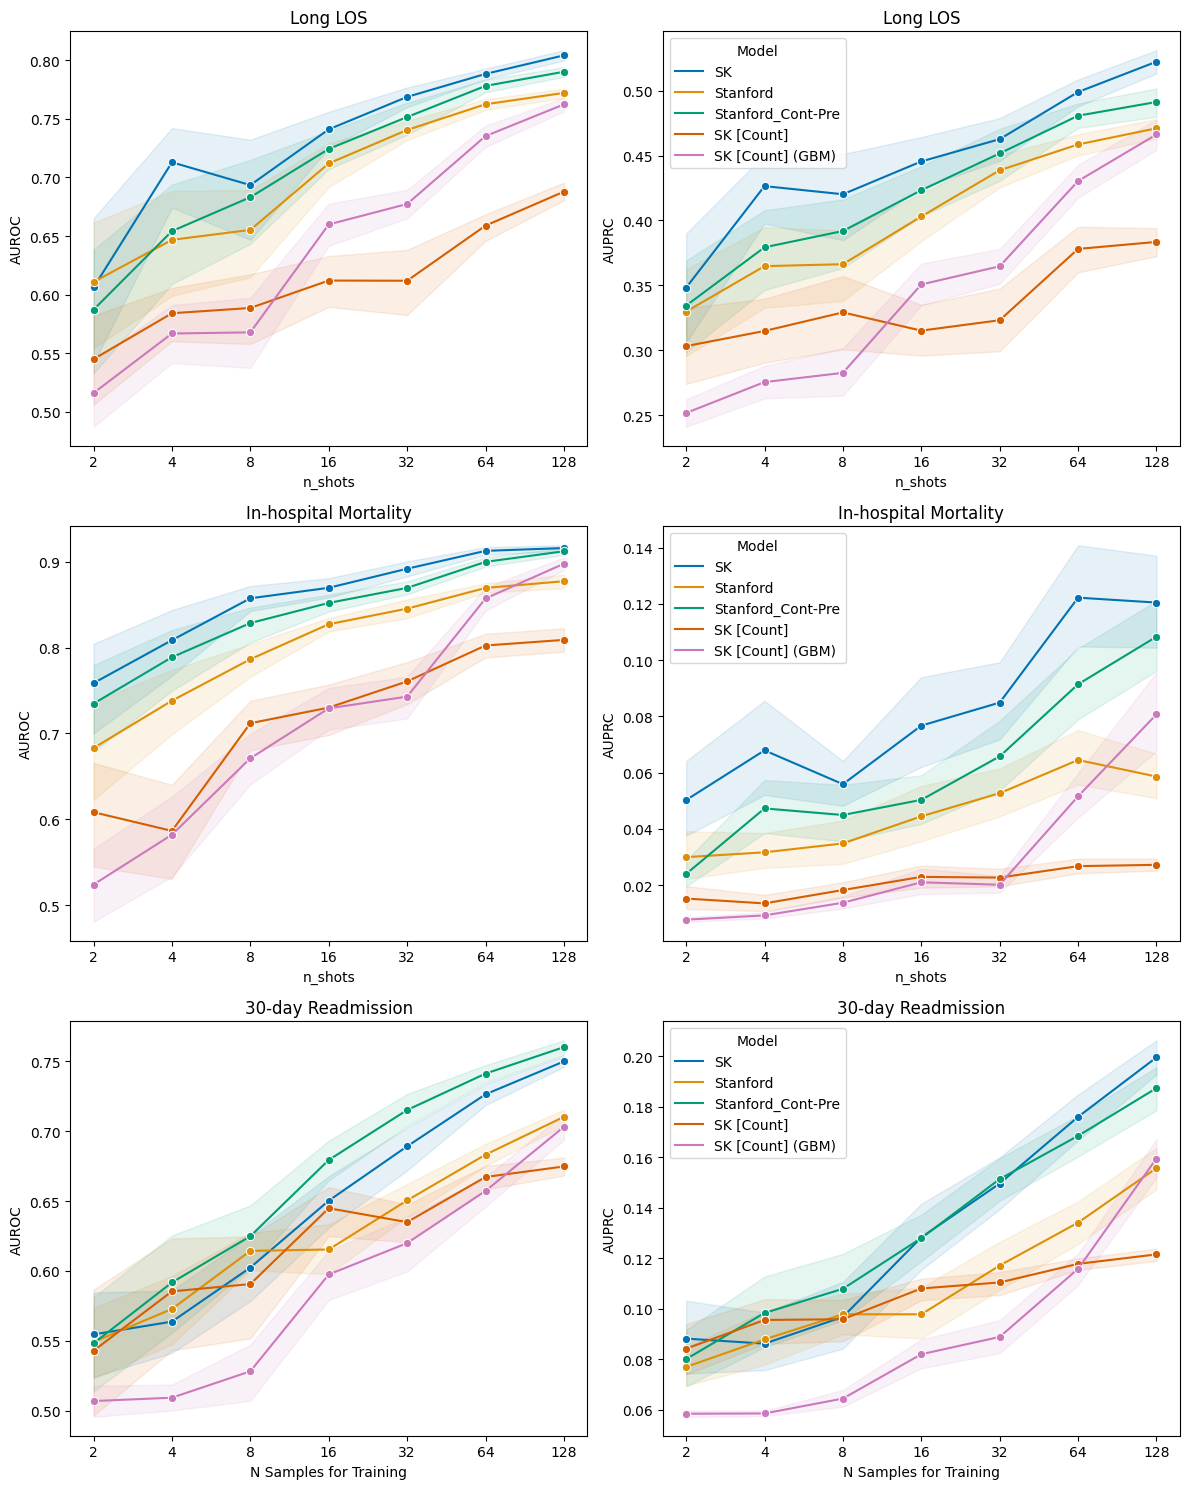

In [7]:
# By Task
tasks = ['long_los', 'mortality', 'readmission']
models = ['count_sk', 'count_sk_gbm', 'clmbr_sk', 'clmbr_stanford', 'clmbr_stanford_cp']

df_mean = (
    df_results.query("Task==@tasks and Model==@models")
    .groupby(["n_shots", "Model", "Task", "train_iter"])
    [["AUROC", "AUPRC"]]
    .first()
    .reindex(["2", "4", "8", "16", "32", "64", "128"], level=0)
    .reset_index()
    .replace({**model_names, **task_names})
)

models = df_mean["Model"].unique().tolist()

fig, axes = plt.subplots(len(tasks),2,figsize=(12,5*len(tasks)))
for r, task in enumerate(tasks):
    task_name = task_names[task]
    for c, metric in enumerate(["AUROC", "AUPRC"]):
        sns.lineplot(
            data = df_mean.query("Task==@task_name"),
            x = "n_shots",
            y = metric,
            hue = "Model",
            ax = axes[r][c],
            legend = True if c==1 else False,
            marker = "o",
            palette = "colorblind",
            errorbar = "ci",
            n_boot = 10000,
            err_kws = {"alpha":0.1}
        )

        axes[r][c].set_title(task_name)
        
        if r == len(tasks)-1:
            axes[r][c].set_xlabel("N Samples for Training")
        else:
            axes[r][c].set_label("")
        
plt.tight_layout()
plt.show()